In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import roc_auc_score

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess-gpu'

PATH_PARAM = '../input/optuna-catboost'

In [2]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [3]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

In [4]:
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

FOLD_LIST = range(train[FOLD_STRAT_NAME].nunique())

gc.collect()

30

# Set parameter

In [5]:
params = {
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'verbose': 100,
    'random_state':RANDOM_STATE,
    'task_type' : 'GPU',
    'early_stopping_rounds' : 100,
    'iterations': 100000,
    'learning_rate': .005,
    'metric_period': 25,
}

#import lgb optimized parameter (file_name is wrong :()
with open(os.path.join(PATH_PARAM, 'final_cb_param.pkl'), 'rb') as file:
    param_lgb_final = pickle.load(file)
    
params.update(param_lgb_final)

#pretty print
print(json.dumps(params, indent=4))

{
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "verbose": 100,
    "random_state": 383920,
    "task_type": "GPU",
    "early_stopping_rounds": 100,
    "iterations": 100000,
    "learning_rate": 0.005,
    "metric_period": 25,
    "depth": 4,
    "bagging_temperature": 1.1418824362276156,
    "l2_leaf_reg": 4.509209960369067,
    "random_strength": 0.8823223562163118,
    "min_data_in_leaf": 5
}


# TRAIN

In [6]:
score = 0
model_list = []

prediction_df = pd.DataFrame(
    {
        'fold': train[FOLD_STRAT_NAME],
        'prediction': np.zeros((train.shape[0]))
    }
)


for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = cb.CatBoostClassifier(**params)
    
    train_pool = cb.Pool(train_x, label= train_y, cat_features = CAT_COL)
    valid_pool = cb.Pool(test_x, label= test_y, cat_features = CAT_COL)
    
    model.fit(train_pool, eval_set = valid_pool, verbose=True, use_best_model=True)
    
    pred_prob = model.predict_proba(test_x)[:, 1]
    
    #oof prediction
    prediction_df.loc[mask_test, 'prediction'] = pred_prob
    
    #evaluate score and save model for importance/prediction
    score_fold = roc_auc_score(test_y, pred_prob)
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Auc: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Auc: {:.5f}\n'.format(score))

0:	learn: 0.8150778	test: 0.8149687	best: 0.8149687 (0)	total: 29ms	remaining: 48m 21s
25:	learn: 0.8208231	test: 0.8207972	best: 0.8207972 (25)	total: 522ms	remaining: 33m 28s
50:	learn: 0.8217658	test: 0.8218145	best: 0.8219917 (47)	total: 992ms	remaining: 32m 24s
75:	learn: 0.8225929	test: 0.8226834	best: 0.8226847 (74)	total: 1.45s	remaining: 31m 51s
100:	learn: 0.8241197	test: 0.8242777	best: 0.8242777 (100)	total: 1.91s	remaining: 31m 33s
125:	learn: 0.8248944	test: 0.8250357	best: 0.8250357 (125)	total: 2.38s	remaining: 31m 26s
150:	learn: 0.8253440	test: 0.8254499	best: 0.8254598 (149)	total: 2.86s	remaining: 31m 28s
175:	learn: 0.8265011	test: 0.8265579	best: 0.8265579 (175)	total: 3.33s	remaining: 31m 25s
200:	learn: 0.8271419	test: 0.8271530	best: 0.8271530 (200)	total: 3.79s	remaining: 31m 21s
225:	learn: 0.8277376	test: 0.8277321	best: 0.8277321 (225)	total: 4.29s	remaining: 31m 31s
250:	learn: 0.8284279	test: 0.8284094	best: 0.8284306 (248)	total: 4.76s	remaining: 31m 31s

# Feature importance

In [7]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    imp_temp = model.get_feature_importance()
    
    feature_importances['fold_{}'.format(fold_ + 1)] = imp_temp

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

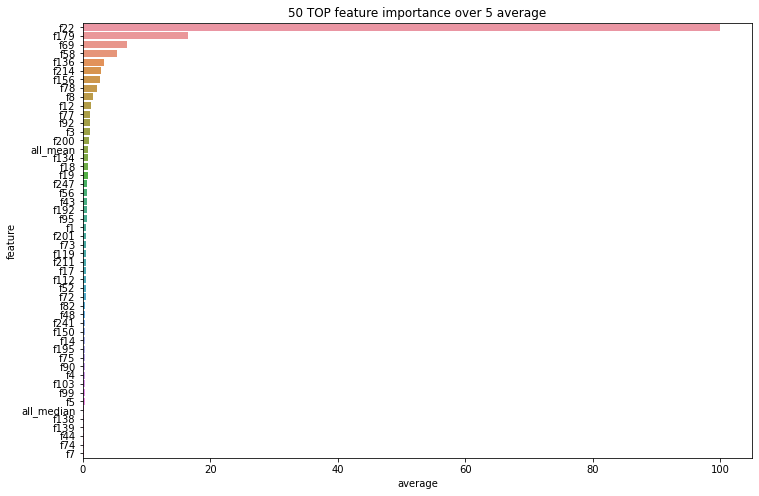

In [8]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [9]:
del train
gc.collect()

36

In [10]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [11]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += (model.predict_proba(test)[:, 1]/N_FOLD)

# SAVE RESULT

In [12]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)

In [13]:
prediction_df.to_csv('oof_prediction', index = False)